# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: learn $B^\mathrm{PP} \to (W^\mathrm{PP})^T$

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of L-DRL.

## Definitions

In [173]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

## Learn $B = W^T$

We make another example with a network of size [4-30-3].

### Setup

In [151]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
images = 3000
epochs = 10

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [5e-2]

In [152]:
np.random.seed(123456)

# Init model: weights, voltages

layers = [4, 30, 3]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [200.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # not needed, as we init in self-predicting state and WPP is fixed
eta_PI = [1.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    

INIT_CONST = 1
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i], layers[-1])))

In [153]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(-1, 1, size=(images, layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

In [154]:
mc2 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=True,
                         noise_mode='uP',
                         model='LDRL',
                         activation=relu, layers=layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2.set_self_predicting_state()

In [155]:
# check alignment between WPP.T and BPP before learning
cos_sim(mc2.BPP[0], mc2.WPP[1].T)

-0.17262518471583263

### Simulation

In [156]:
mc2.init_record(rec_per_steps=1000, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True)

for j in range(epochs):
    print(f'Working on epoch {j}')
    for i in range(len(r0_random)):
        mc2.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt BPI and BPP

Working on epoch 0
Working on epoch 1
Working on epoch 2
Working on epoch 3
Working on epoch 4
Working on epoch 5
Working on epoch 6
Working on epoch 7
Working on epoch 8
Working on epoch 9


Check that BPP and BPI learn approx at same speed:

In [157]:
print(np.mean(mc2.dBPP[0]), np.std(mc2.dBPP[0]))

-5.834663627926438e-08 4.6939216563509844e-07


In [158]:
print(np.mean(mc2.dBPI[0]), np.std(mc2.dBPI[0]))

-1.3757990040562777e-08 9.54196213822173e-07


In [159]:
# # fig = plt.figure()
# # rP = [rP[0] for rP in rPbreve_time_series]
# # plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# # plt.show()

# fig = plt.figure()
# rP = [rP[1] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
# plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
# plt.legend()
# plt.title("Denoising in interneuron")
# plt.xlabel('dt')
# plt.show()


# fig = plt.figure()
# rPbreve_HI = [rPbreve_HI[1] for rPbreve_HI in rPbreve_HI_time_series]
# plt.plot(np.array(rPbreve_HI[int(Tpres/dt):]).ravel(), label="$\widehat{\\varphi{(\\breve{u}^P)}}$")
# plt.xlabel('dt')
# plt.title("High-pass filtering")
# plt.legend()
# plt.show()

# fig = plt.figure()
# xibreve = [xibreve[0] for xibreve in xibreve_time_series]
# plt.plot(np.array(xibreve[int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
# plt.title("Lookahead of noise")
# plt.xlabel('dt')
# plt.legend()
# plt.show()

In [160]:
# for i in range(layers[-1]):
    
#     # plot neuron outputs in output layer

#     fig = plt.figure()
#     plt.plot(np.array(rIbreve_time_series).T[i][0])
#     plt.plot(np.array(rPbreve_time_series).T[i][1])
#     plt.show()
    
# # check apical potentials

# fig = plt.figure()
# plt.plot(np.array(vapi_time_series).T[0][0])
# plt.plot(np.array(vapi_time_series).T[1][0])
# plt.show()


Now, let's check angle between BPP and WPP.T:

In [161]:
# cos_BPI_BPP = []
# for i in range(len(BPI_time_series[0])):
#     cos_BPI_BPP.append(np.array([
#         cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
#                            ]))
    
# cos_WIP_WPP = []
# for i in range(len(WIP_time_series[0])):
#     cos_WIP_WPP.append(np.array([
#         cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
#                            ]))
    
mc2.cos_WPPtrans_BPP = []
for i in range(len(mc2.BPP_time_series[0])):
    mc2.cos_WPPtrans_BPP.append(np.array([
        cos_sim(mc2.BPP_time_series[j][i], WPP_init[i+1].T) for j in range(0, len(mc2.BPP_time_series), 1)
                           ]))

BPP at init:

In [162]:
# mc2.BPP_time_series[0][0]

BPP after learning:

In [163]:
# mc2.BPP_time_series[-1][0]

WPP^T (fixed):

In [164]:
# mc2.WPP_time_series[0][1].T

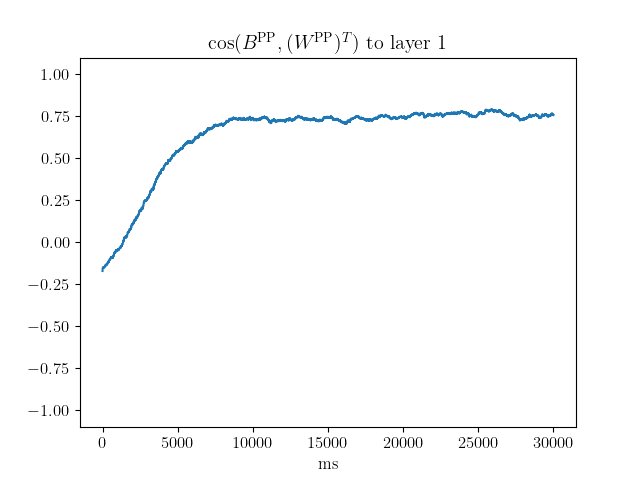

In [165]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc2.cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = 'ms'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

    # fig, ax = plt.subplots()
    # ax.plot([WPP_init[i+1].T.ravel() for WPP in BPP_time_series], label="WPP.T")
    # ax.plot([BPP[i].ravel() for BPP in BPP_time_series], label="BPP", linestyle="--")
    # plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    # plt.ylabel("B")
    # plt.legend()
    # # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    # plt.show()

In [166]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(cos_BPI_BPP[i], label='$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
#     # ax.plot(cos_rIbreveBPI_rPbreveBPP[i], label='$\cos(r^\mathrm{PI}, -r^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.legend()
#     plt.ylim(-1.1,1.1)
#     plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array(BPI_time_series).ravel(), label="BPI")
# ax.plot(-np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

In [167]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()